<a href="https://colab.research.google.com/github/kunal-bianalyst/Chiller_Reliabillity_Analysis/blob/main/ChillersReliabilityAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install and Import Required Libraries**

In [86]:
# Step 1: Install required libraries
!pip install --quiet pandas numpy matplotlib scipy scikit-learn tensorflow==2.12.0 lifelines statsmodels seaborn plotly sdv ctgan

# Reduce unnecessary TensorFlow logs
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("✅ Environment setup complete")

ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0
✅ Environment setup complete


**CSV file into Colab**

In [87]:
# Step 2A: Upload CSV directly from your computer
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()

# Pick the uploaded file
for fn in uploaded.keys():
    print("Uploaded file:", fn)
    DATA_FILE = fn  # store filename

Saving HVAC_NE_EC_19-21.csv to HVAC_NE_EC_19-21 (2).csv
Uploaded file: HVAC_NE_EC_19-21 (2).csv



**Load & Inspect Data.**

In [88]:
# Step 3: Load CSV into DataFrame

import pandas as pd

# Read the file (already uploaded in Step 2)
try:
    df = pd.read_csv(DATA_FILE, encoding="latin-1")
except Exception as e:
    print("⚠️ Error reading file:", e)
    import glob
    files = glob.glob("*.csv")
    print("Available CSV files:", files)
    df = pd.read_csv(files[0], encoding="latin-1")

# Clean up column names by stripping whitespace
df.columns = df.columns.str.strip()

# Show basic info
print("✅ Dataset loaded")
print("Shape (rows, columns):", df.shape)
print("\nColumns:", df.columns.tolist())

# Preview first 5 rows
df.head()

✅ Dataset loaded
Shape (rows, columns): (33888, 11)

Columns: ['Timestamp', 'T_Supply (°C)', 'T_Return (°C)', 'SetPt_Return (°C)', 'Humifr_T_Saturation (°C)', 'T_Outdoor (°C)', 'RH_Supply %', 'RH_Return %', 'RH_Outdoor %', 'Energy (KWh)', 'Power (KW)']


,Timestamp,T_Supply (°C),T_Return (°C),SetPt_Return (°C),Humifr_T_Saturation (°C),T_Outdoor (°C),RH_Supply %,RH_Return %,RH_Outdoor %,Energy (KWh),Power (KW)
0,2019-10-15 00:00:00+02:00,19.859999,20.469999,18.5,19.02,20.299999,71.110001,58.919998,79.5,0.0,0.0
1,2019-10-15 00:15:00+02:00,19.855000,20.430000,18.5,19.02,20.299999,71.320000,59.000000,82.0,0.0,0.0
2,2019-10-15 00:30:00+02:00,19.850000,20.410000,18.5,19.02,20.299999,71.470001,59.109997,79.5,0.0,0.0
3,2019-10-15 00:45:00+02:00,19.840000,20.379999,18.5,19.08,20.299999,71.439995,59.309998,77.0,0.0,0.0
4,2019-10-15 01:00:00+02:00,19.830000,20.350000,18.5,19.08,20.299999,71.580002,59.559998,79.5,0.0,0.0


**Data Cleaning & Preprocessing.**

In [90]:
# Step 4: Data Cleaning & Preprocessing
import numpy as np
import pandas as pd

# Convert Timestamp to datetime and then to UTC
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Timestamp'] = df['Timestamp'].dt.tz_convert('UTC')

# Check for missing Timestamps and handle them (e.g., drop rows with NaT)
if df['Timestamp'].isna().sum() > 0:
    print(f"Warning: {df['Timestamp'].isna().sum()} missing Timestamps found and will be dropped.")
    df.dropna(subset=['Timestamp'], inplace=True)


# 1. Check data types
print("Data types:\n", df.dtypes)

# 2. Missing values per column
print("\nMissing values per column:\n", df.isna().sum())

# 3. Convert numeric-looking columns to proper numeric (excluding Timestamp and Remark)
numeric_cols = [col for col in df.columns if col not in ['Timestamp', 'Remark']]
for col in numeric_cols:
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    except:
        pass

# 4. Fill missing values for numeric columns (forward fill, then median if still missing)
# Apply fillna only to numeric columns
df[numeric_cols] = df[numeric_cols].fillna(method="ffill").fillna(df[numeric_cols].median())


# 5. Remove duplicate rows if any
dupes = df.duplicated().sum()
if dupes > 0:
    df = df.drop_duplicates()
    print(f"Dropped {dupes} duplicate rows")

print("\n✅ Data cleaned. Final shape:", df.shape)
df.head()

Data types:
 Timestamp                   datetime64[ns, UTC]
T_Supply (°C)                           float64
T_Return (°C)                           float64
SetPt_Return (°C)                       float64
Humifr_T_Saturation (°C)                float64
T_Outdoor (°C)                          float64
RH_Supply %                             float64
RH_Return %                             float64
RH_Outdoor %                            float64
Energy (KWh)                            float64
Power (KW)                              float64
dtype: object

Missing values per column:
 Timestamp                   0
T_Supply (°C)               0
T_Return (°C)               0
SetPt_Return (°C)           0
Humifr_T_Saturation (°C)    0
T_Outdoor (°C)              0
RH_Supply %                 0
RH_Return %                 0
RH_Outdoor %                0
Energy (KWh)                0
Power (KW)                  0
dtype: int64

✅ Data cleaned. Final shape: (5200, 11)


/tmp/ipython-input-1659213236.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method="ffill").fillna(df[numeric_cols].median())


,Timestamp,T_Supply (°C),T_Return (°C),SetPt_Return (°C),Humifr_T_Saturation (°C),T_Outdoor (°C),RH_Supply %,RH_Return %,RH_Outdoor %,Energy (KWh),Power (KW)
0,2019-10-14 22:00:00+00:00,19.859999,20.469999,18.5,19.02,20.299999,71.110001,58.919998,79.5,0.0,0.0
1,2019-10-14 22:15:00+00:00,19.855000,20.430000,18.5,19.02,20.299999,71.320000,59.000000,82.0,0.0,0.0
2,2019-10-14 22:30:00+00:00,19.850000,20.410000,18.5,19.02,20.299999,71.470001,59.109997,79.5,0.0,0.0
3,2019-10-14 22:45:00+00:00,19.840000,20.379999,18.5,19.08,20.299999,71.439995,59.309998,77.0,0.0,0.0
4,2019-10-14 23:00:00+00:00,19.830000,20.350000,18.5,19.08,20.299999,71.580002,59.559998,79.5,0.0,0.0


**Handle Missing Values (if any).**

In [91]:
# Step 5: Check for missing values
print("Missing values per column:\n")
print(df.isnull().sum())

# Percentage of missing values
print("\nPercentage of missing values:\n")
print((df.isnull().sum() / len(df)) * 100)


Missing values per column:

Timestamp                   0
T_Supply (°C)               0
T_Return (°C)               0
SetPt_Return (°C)           0
Humifr_T_Saturation (°C)    0
T_Outdoor (°C)              0
RH_Supply %                 0
RH_Return %                 0
RH_Outdoor %                0
Energy (KWh)                0
Power (KW)                  0
dtype: int64

Percentage of missing values:

Timestamp                   0.0
T_Supply (°C)               0.0
T_Return (°C)               0.0
SetPt_Return (°C)           0.0
Humifr_T_Saturation (°C)    0.0
T_Outdoor (°C)              0.0
RH_Supply %                 0.0
RH_Return %                 0.0
RH_Outdoor %                0.0
Energy (KWh)                0.0
Power (KW)                  0.0
dtype: float64


**Basic Data Summary & Statistics.**

In [92]:
# Step 6: Summary statistics
print("Basic Statistical Summary:\n")
print(df.describe())

# Extra info for non-numeric columns
print("\nData Types and Non-Null Counts:\n")
print(df.info())


Basic Statistical Summary:

       T_Supply (°C)  T_Return (°C)  SetPt_Return (°C)  \
count    5200.000000    5200.000000        5200.000000   
mean       21.677151      21.436614          21.973462   
std         2.804448       1.586503           1.145027   
min        14.650000      17.850000          18.500000   
25%        19.709999      20.250000          21.500000   
50%        20.695000      21.312499          22.500000   
75%        23.094999      22.629999          22.500000   
max        29.754999      25.990000          23.500000   

       Humifr_T_Saturation (°C)  T_Outdoor (°C)  RH_Supply %  RH_Return %  \
count               5200.000000     5200.000000  5200.000000  5200.000000   
mean                  20.334090       17.400057    49.820384    41.445853   
std                    2.141008        5.269861    15.807700    16.399106   
min                   12.980000        5.600000    19.939999    11.730000   
25%                   18.980000       14.300000    37.637499    

**Data Visualization (EDA plots).**

In [93]:
# Step 7: Visualization setup
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look better
plt.style.use("seaborn-v0_8")


**Correlation Heatmap (relation between variables)**



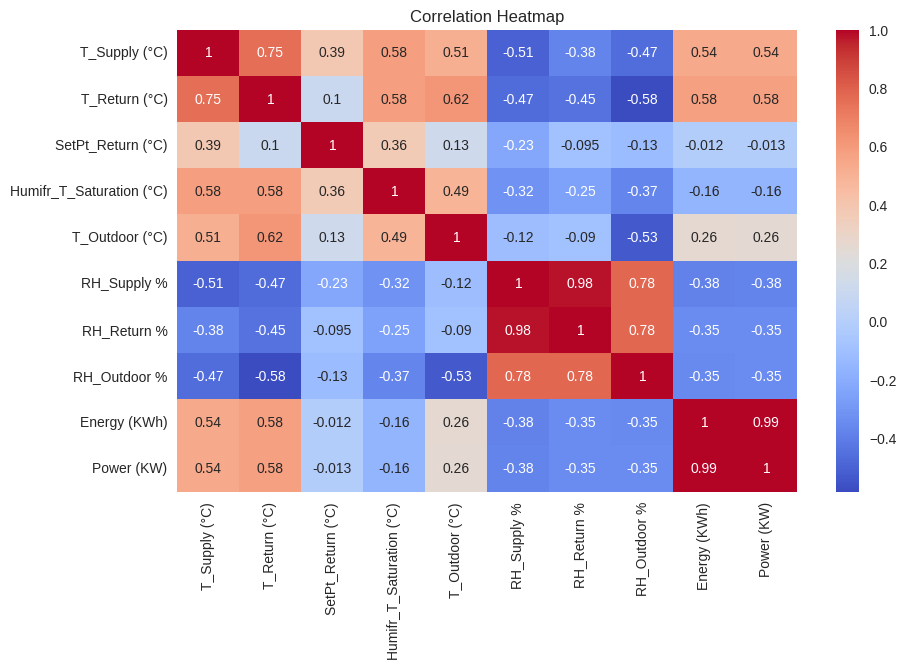

In [94]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


**Distribution of Each Column**

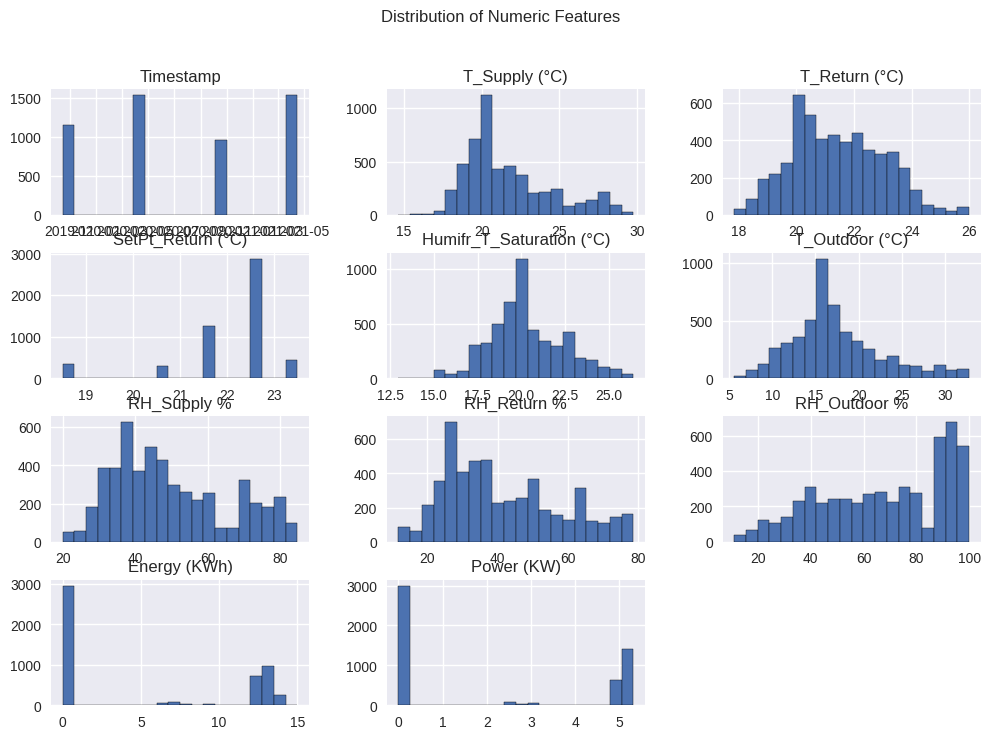

In [95]:
df.hist(figsize=(12,8), bins=20, edgecolor='black')
plt.suptitle("Distribution of Numeric Features")
plt.show()

**Trend Over Time (if dataset has Date/Time column)**

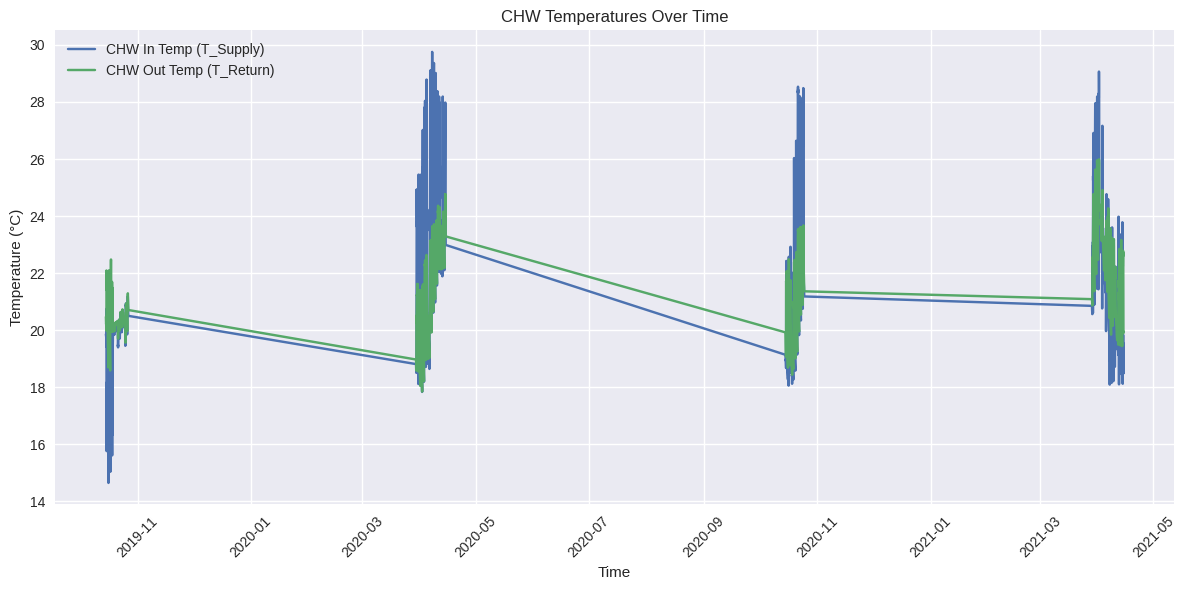

In [96]:
plt.figure(figsize=(12,6))
plt.plot(df['Timestamp'], df['T_Supply (°C)'], label="CHW In Temp (T_Supply)")
plt.plot(df['Timestamp'], df['T_Return (°C)'], label="CHW Out Temp (T_Return)")
plt.legend()
plt.title("CHW Temperatures Over Time")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Feature Engineering**

**Calculate CHW ΔT (Delta T)**

In [97]:
df['CHW_DeltaT'] = df['T_Return (°C)'] - df['T_Supply (°C)']


**Calculate Power per Energy Efficiency Index (kW/ΔT)**

In [98]:
df['Efficiency_kW_per_DeltaT'] = df['Power (KW)'] / df['CHW_DeltaT']


**Define System Health Flag**

In [99]:
import numpy as np

df['Remark'] = np.where(df['CHW_DeltaT'] < 0,
                        "Suspicious: Possible sensor issue",
                 np.where(df['Power (KW)'] == 0,
                          "Power flicker – trip occurred",
                          "System Healthy"))


**Reliability Metrics Prep**

In [100]:
df['Failure_Event'] = np.where(df['Remark'] != "System Healthy", 1, 0)


**Verify**

In [101]:
print(df[['Timestamp','T_Supply (°C)','T_Return (°C)','CHW_DeltaT','Efficiency_kW_per_DeltaT','Remark','Failure_Event']].head(10))


                  Timestamp  T_Supply (°C)  T_Return (°C)  CHW_DeltaT  \
0 2019-10-14 22:00:00+00:00      19.859999      20.469999    0.610000   
1 2019-10-14 22:15:00+00:00      19.855000      20.430000    0.575000   
2 2019-10-14 22:30:00+00:00      19.850000      20.410000    0.560000   
3 2019-10-14 22:45:00+00:00      19.840000      20.379999    0.539999   
4 2019-10-14 23:00:00+00:00      19.830000      20.350000    0.520000   
5 2019-10-14 23:15:00+00:00      19.830000      20.320000    0.490000   
6 2019-10-14 23:30:00+00:00      19.834999      20.309999    0.475000   
7 2019-10-14 23:45:00+00:00      19.824999      20.299999    0.475000   
8 2019-10-15 00:00:00+00:00      19.820000      20.270000    0.450000   
9 2019-10-15 00:15:00+00:00      19.809999      20.260000    0.450001   

   Efficiency_kW_per_DeltaT                         Remark  Failure_Event  
0                       0.0  Power flicker – trip occurred              1  
1                       0.0  Power flicker –

**Reliability Analysis**

**Calculate Time Between Failures (TBF)**

In [102]:
# Check available columns
print(df.columns.tolist())

# Example: Count unique failure events if stored in 'Remark'
print("\nUnique failure events count:")
print(df['Remark'].value_counts())

# Calculate Time Between Failures (TBF)
# Filter for rows where a failure event occurred
failures = df[df['Failure_Event'] == 1].copy()

# Ensure Timestamp is datetime type - This is now handled in data cleaning
# failures['Timestamp'] = pd.to_datetime(failures['Timestamp'], utc=True, errors='coerce')

# Sort by timestamp
failures = failures.sort_values('Timestamp')

# Calculate the time difference between consecutive failures
failures['TBF'] = failures['Timestamp'].diff().dt.total_seconds() / 3600  # in hours

# Remove the first row which will have NaN for TBF
failures = failures.dropna(subset=['TBF'])

print("\nFailures DataFrame with TBF:")
print(failures[['Timestamp', 'Remark', 'TBF']].head())

# Basic statistics of TBF
print("\nTBF Statistics (in hours):")
print(failures['TBF'].describe())

['Timestamp', 'T_Supply (°C)', 'T_Return (°C)', 'SetPt_Return (°C)', 'Humifr_T_Saturation (°C)', 'T_Outdoor (°C)', 'RH_Supply %', 'RH_Return %', 'RH_Outdoor %', 'Energy (KWh)', 'Power (KW)', 'CHW_DeltaT', 'Efficiency_kW_per_DeltaT', 'Remark', 'Failure_Event']

Unique failure events count:
Remark
Power flicker – trip occurred        2715
Suspicious: Possible sensor issue    1644
System Healthy                        841
Name: count, dtype: int64

Failures DataFrame with TBF:
                  Timestamp                         Remark   TBF
1 2019-10-14 22:15:00+00:00  Power flicker – trip occurred  0.25
2 2019-10-14 22:30:00+00:00  Power flicker – trip occurred  0.25
3 2019-10-14 22:45:00+00:00  Power flicker – trip occurred  0.25
4 2019-10-14 23:00:00+00:00  Power flicker – trip occurred  0.25
5 2019-10-14 23:15:00+00:00  Power flicker – trip occurred  0.25

TBF Statistics (in hours):
count    4358.000000
mean        3.017841
std       103.757473
min         0.250000
25%         0.25000

In [ ]:
print(df.columns.tolist())


In [103]:
# Count event types in Remarks
event_counts = df['Remark'].value_counts()
print(event_counts)


Remark
Power flicker – trip occurred        2715
Suspicious: Possible sensor issue    1644
System Healthy                        841
Name: count, dtype: int64


**Visualize failure events**

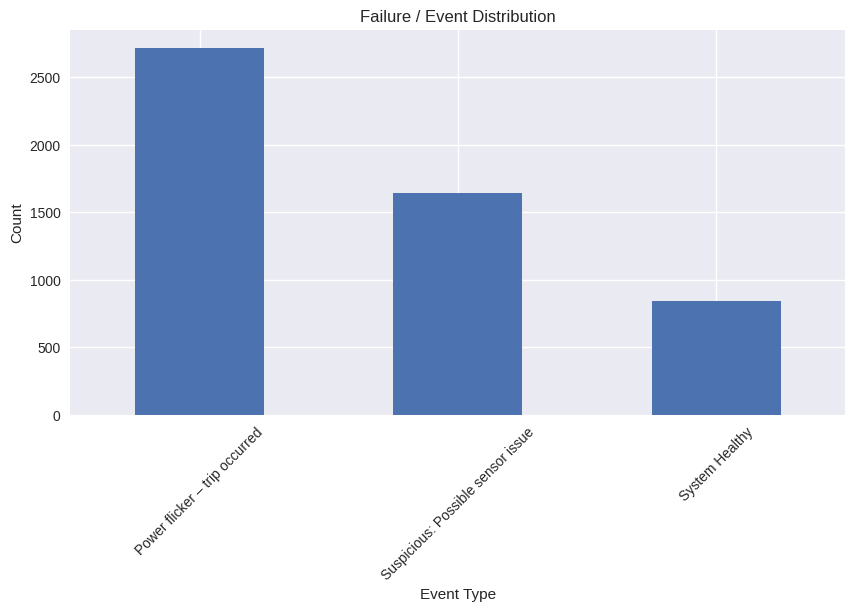

In [104]:
plt.figure(figsize=(10,5))
event_counts.plot(kind='bar')
plt.title("Failure / Event Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


**Summary statistics & initial insights**

In [105]:
# Summary statistics for numeric columns
print(df.describe())

# For non-numeric columns (like categorical or remarks)
print(df.describe(include=['object']))


       T_Supply (°C)  T_Return (°C)  SetPt_Return (°C)  \
count    5200.000000    5200.000000        5200.000000   
mean       21.677151      21.436614          21.973462   
std         2.804448       1.586503           1.145027   
min        14.650000      17.850000          18.500000   
25%        19.709999      20.250000          21.500000   
50%        20.695000      21.312499          22.500000   
75%        23.094999      22.629999          22.500000   
max        29.754999      25.990000          23.500000   

       Humifr_T_Saturation (°C)  T_Outdoor (°C)  RH_Supply %  RH_Return %  \
count               5200.000000     5200.000000  5200.000000  5200.000000   
mean                  20.334090       17.400057    49.820384    41.445853   
std                    2.141008        5.269861    15.807700    16.399106   
min                   12.980000        5.600000    19.939999    11.730000   
25%                   18.980000       14.300000    37.637499    27.849998   
50%            

**Histograms for Temperature & Pressure**

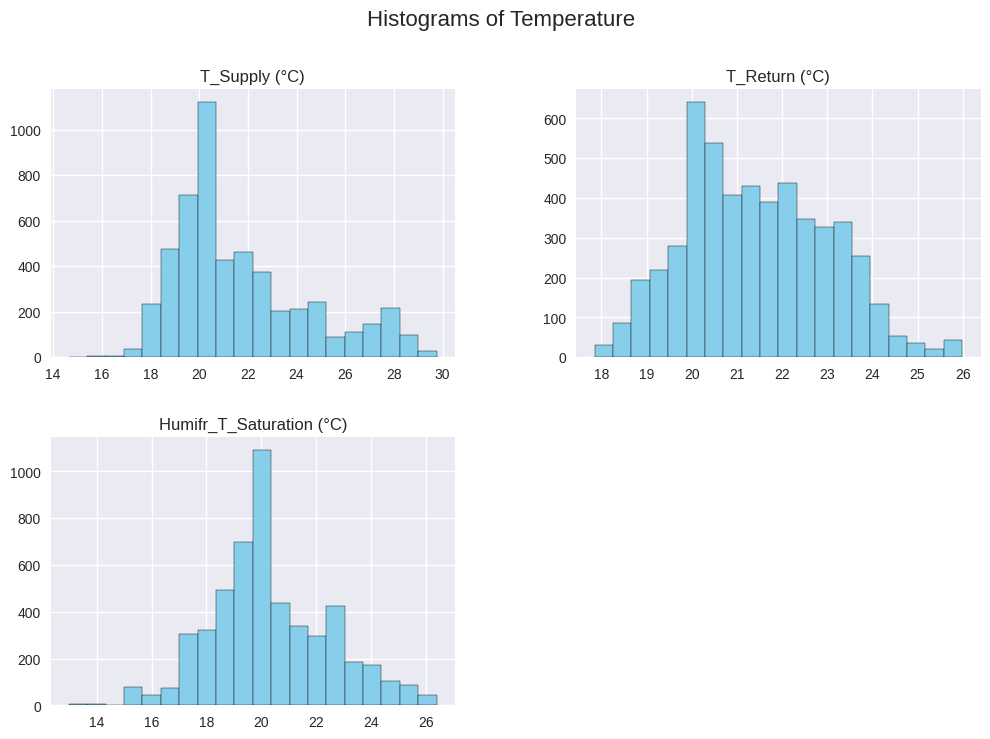

In [106]:
# Select columns for histograms
columns_to_plot = ['T_Supply (°C)', 'T_Return (°C)', 'Humifr_T_Saturation (°C)']

# Plot histograms
df[columns_to_plot].hist(bins=20, figsize=(12,8), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Temperature', fontsize=16)
plt.show()

**Correlation Heatmap**

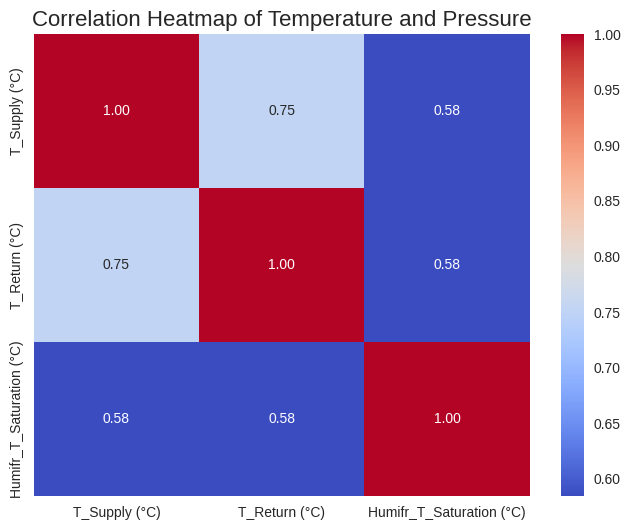

In [107]:
# Compute correlation matrix
corr = df[columns_to_plot].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Temperature and Pressure', fontsize=16)
plt.show()


**Time-Series Patterns**

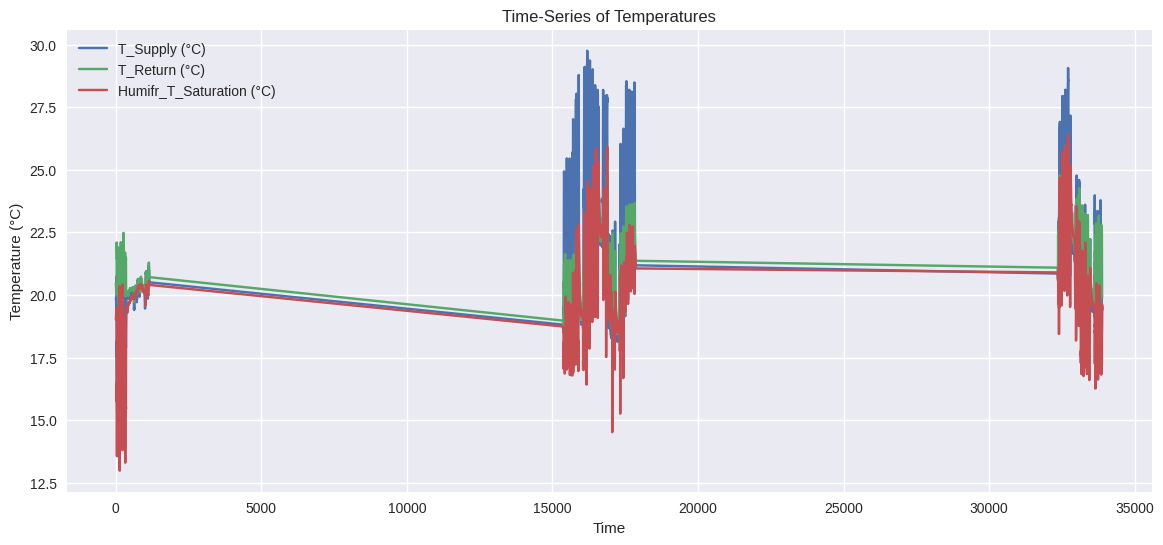

In [108]:
# Plot time-series for temperatures
plt.figure(figsize=(14,6))
plt.plot(df.index, df['T_Supply (°C)'], label='T_Supply (°C)')
plt.plot(df.index, df['T_Return (°C)'], label='T_Return (°C)')
plt.plot(df.index, df['Humifr_T_Saturation (°C)'], label='Humifr_T_Saturation (°C)')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Time-Series of Temperatures')
plt.legend()
plt.show()